# Training

In [1]:
import os
import glob
from treecat_exp.util import load_object
from matplotlib import pyplot
import numpy as np
import torch
from pyro.contrib.tabular.treecat import print_tree
%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
# %config InlineBackend.figure_format = 'svg'

To perform training, run `python train.py`

In [9]:
DATASET = 'census.treecatnuts.16'
meta = load_object('results/train/{}.meta.pkl'.format(DATASET))
model = load_object('results/train/{}.model.pkl'.format(DATASET))
print(list(meta.keys()))
args = meta['args']
stepsizes = meta['stepsizes']

['args', 'losses', 'stepsizes', 'memsizes', 'times']


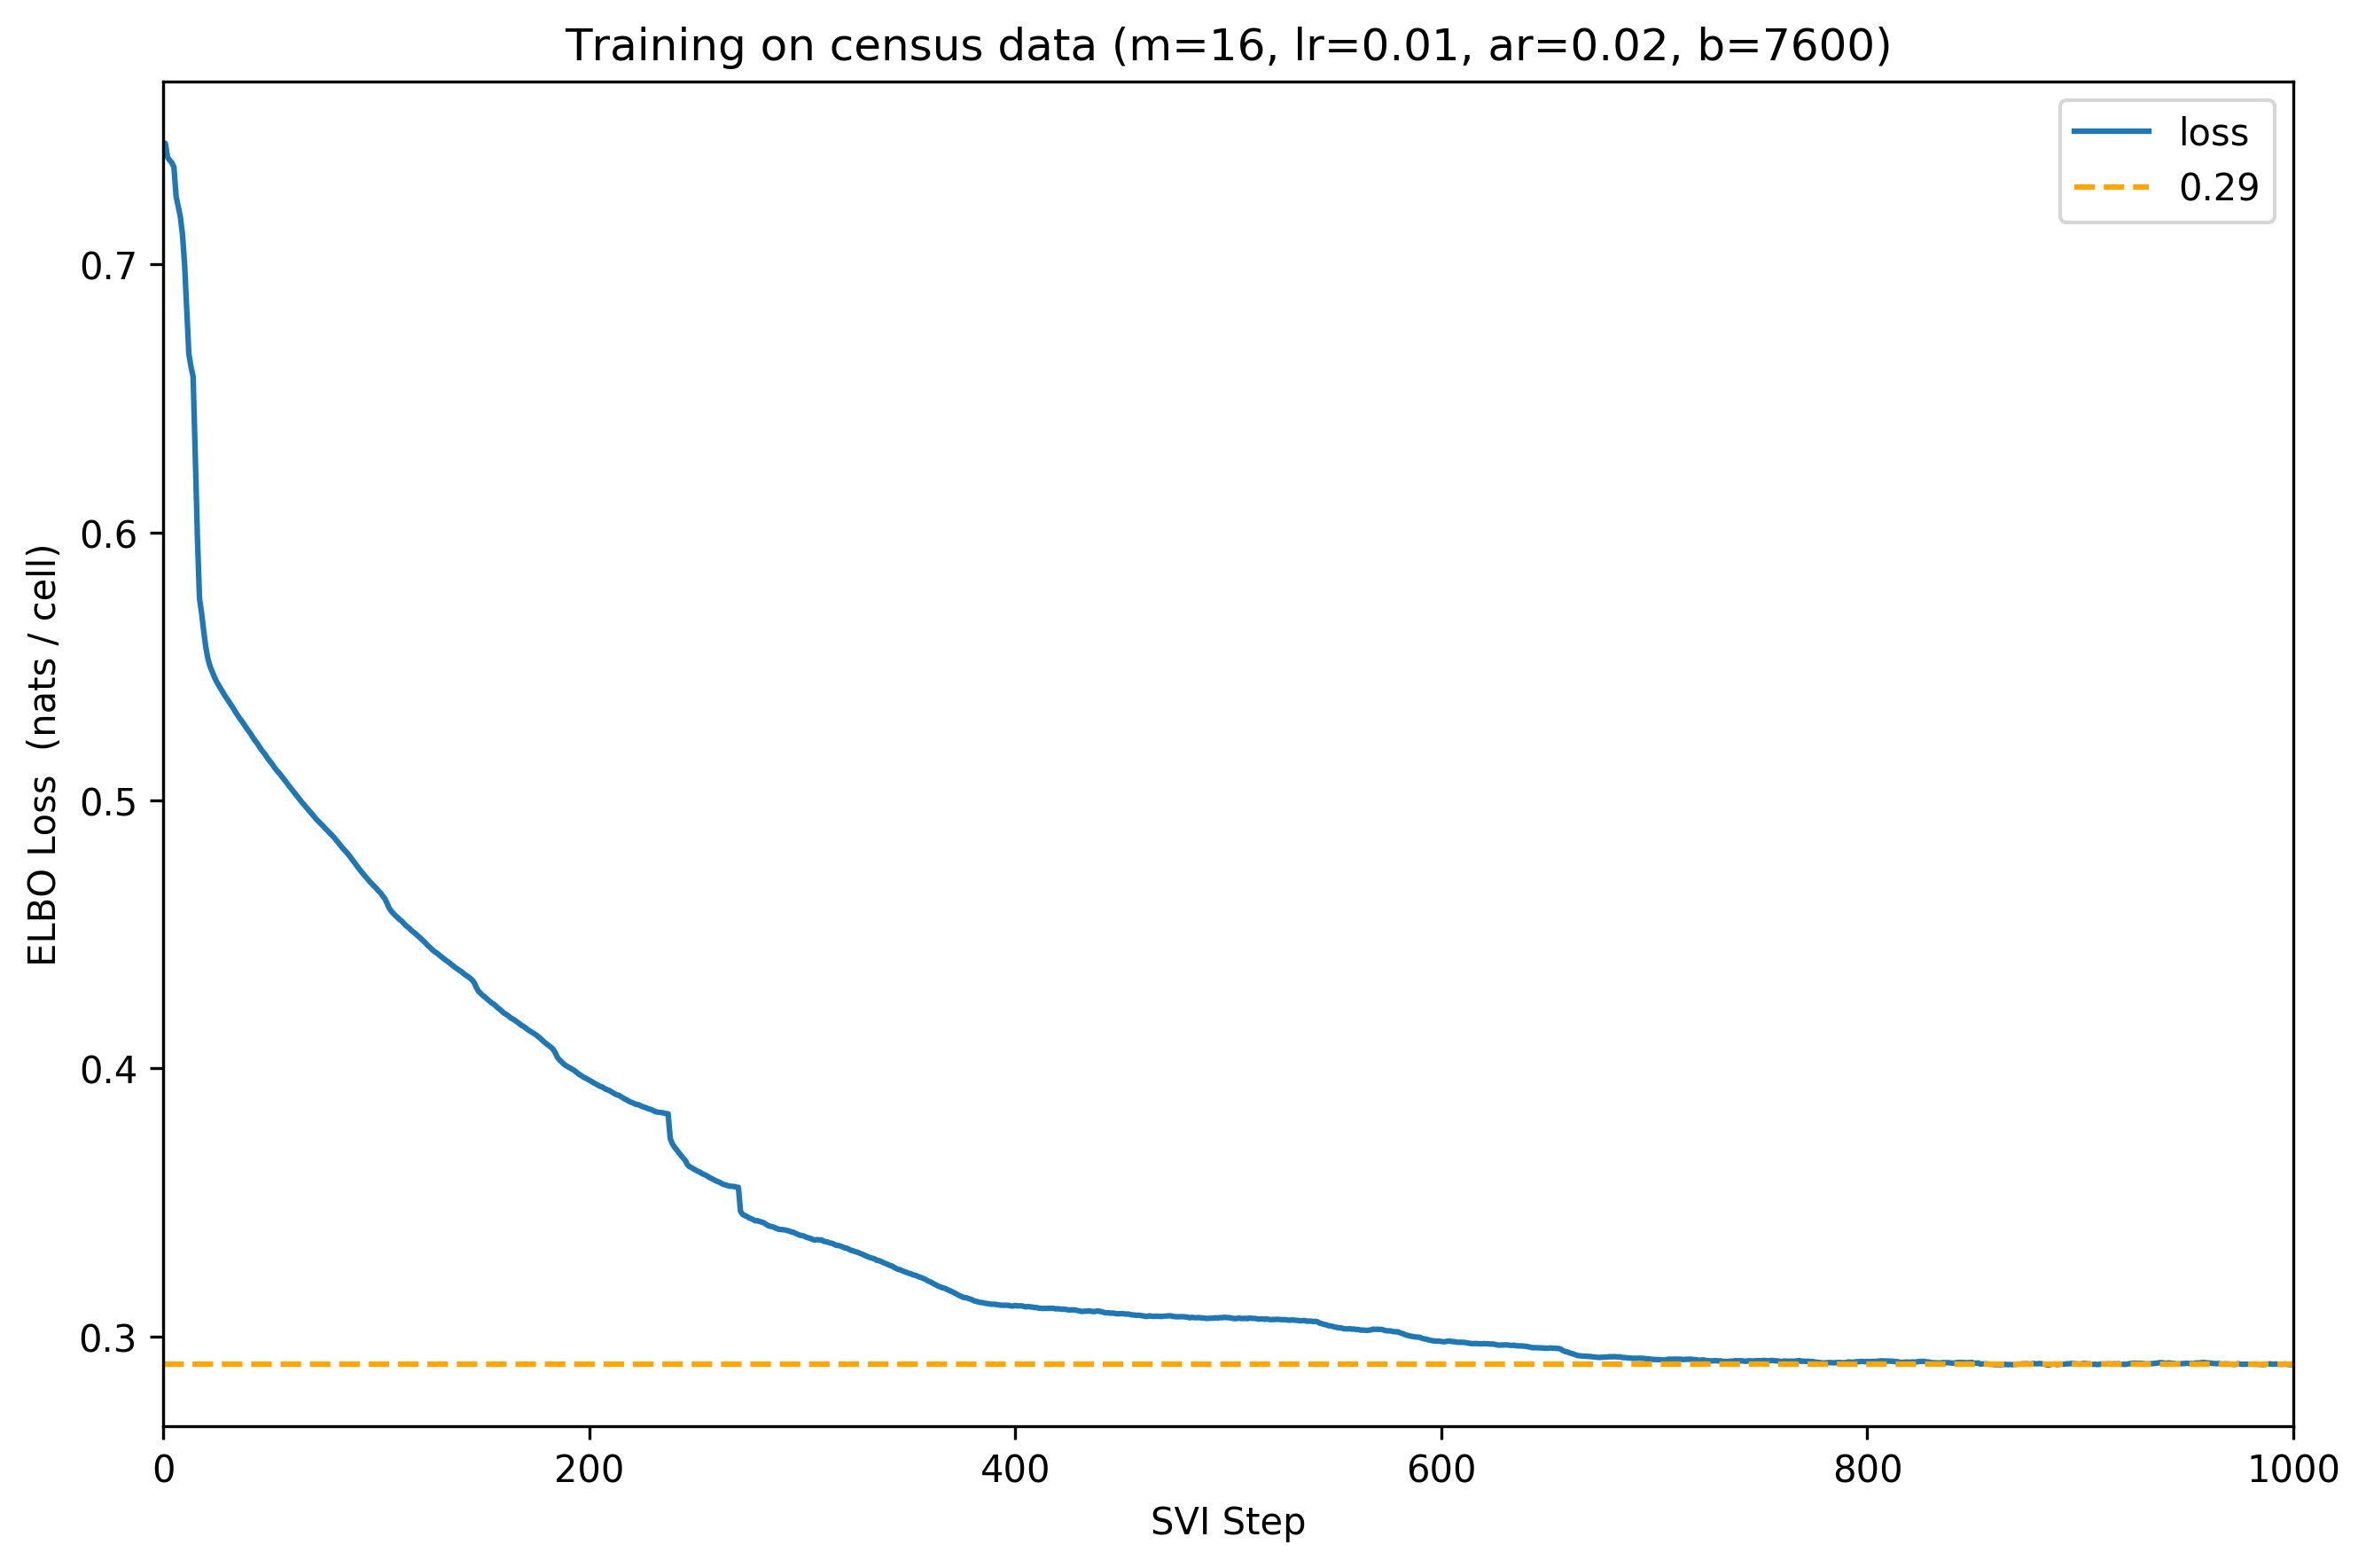

In [10]:
pyplot.figure(figsize=(9, 6), dpi=300)
pyplot.plot(meta['losses'], label='loss')
pyplot.ylabel('ELBO Loss  (nats / cell)')
pyplot.xlabel('SVI Step')
asymptote = np.mean(meta['losses'][int(0.9 * len(meta['losses'])):])
pyplot.axhline(asymptote, color='orange', linestyle='--', lw=1.5,
               label='{:0.3g}'.format(asymptote))
pyplot.xlim(0, len(meta["losses"]))
pyplot.title('Training on {} data (m={}, lr={}, ar={}, b={})'.format(
             args.dataset, args.capacity, args.learning_rate,
             args.annealing_rate, args.batch_size))
pyplot.legend(loc='best')
pyplot.tight_layout()

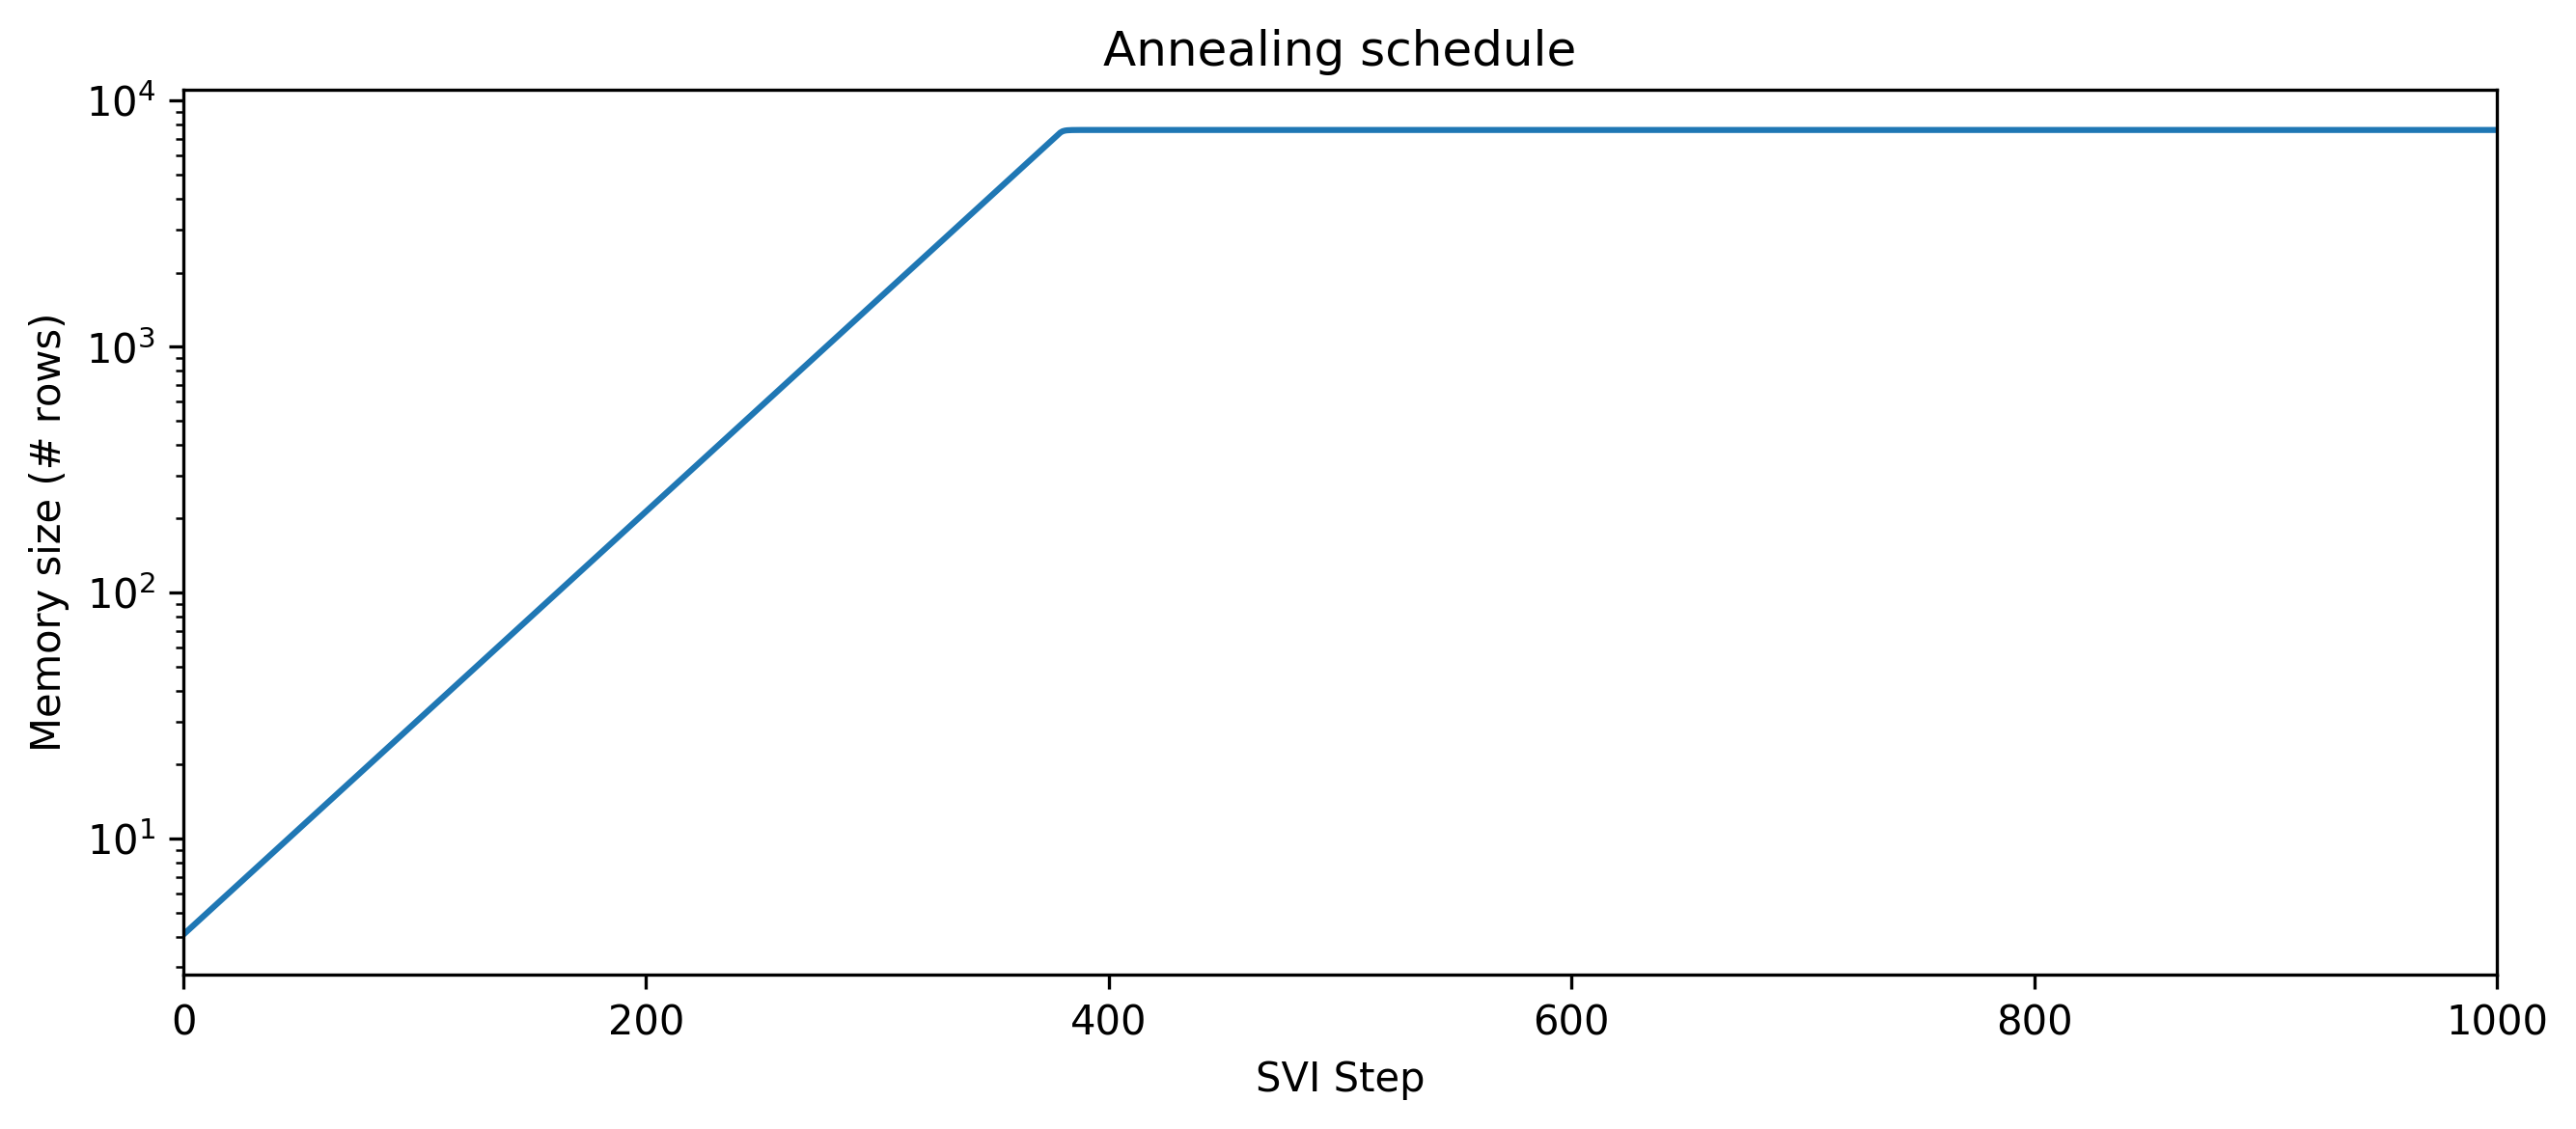

In [11]:
pyplot.figure(figsize=(9, 4), dpi=300)
pyplot.plot(meta['memsizes'])
pyplot.ylabel('Memory size (# rows)')
pyplot.xlabel('SVI Step')
pyplot.xlim(0, len(meta["memsizes"]))
pyplot.yscale('log')
pyplot.title('Annealing schedule')
pyplot.tight_layout()

In [12]:
def downsample(series, factor):
    series = torch.tensor(series)
    series = series[:len(series) // factor * factor]
    return series.reshape(-1, factor).mean(-1).numpy()

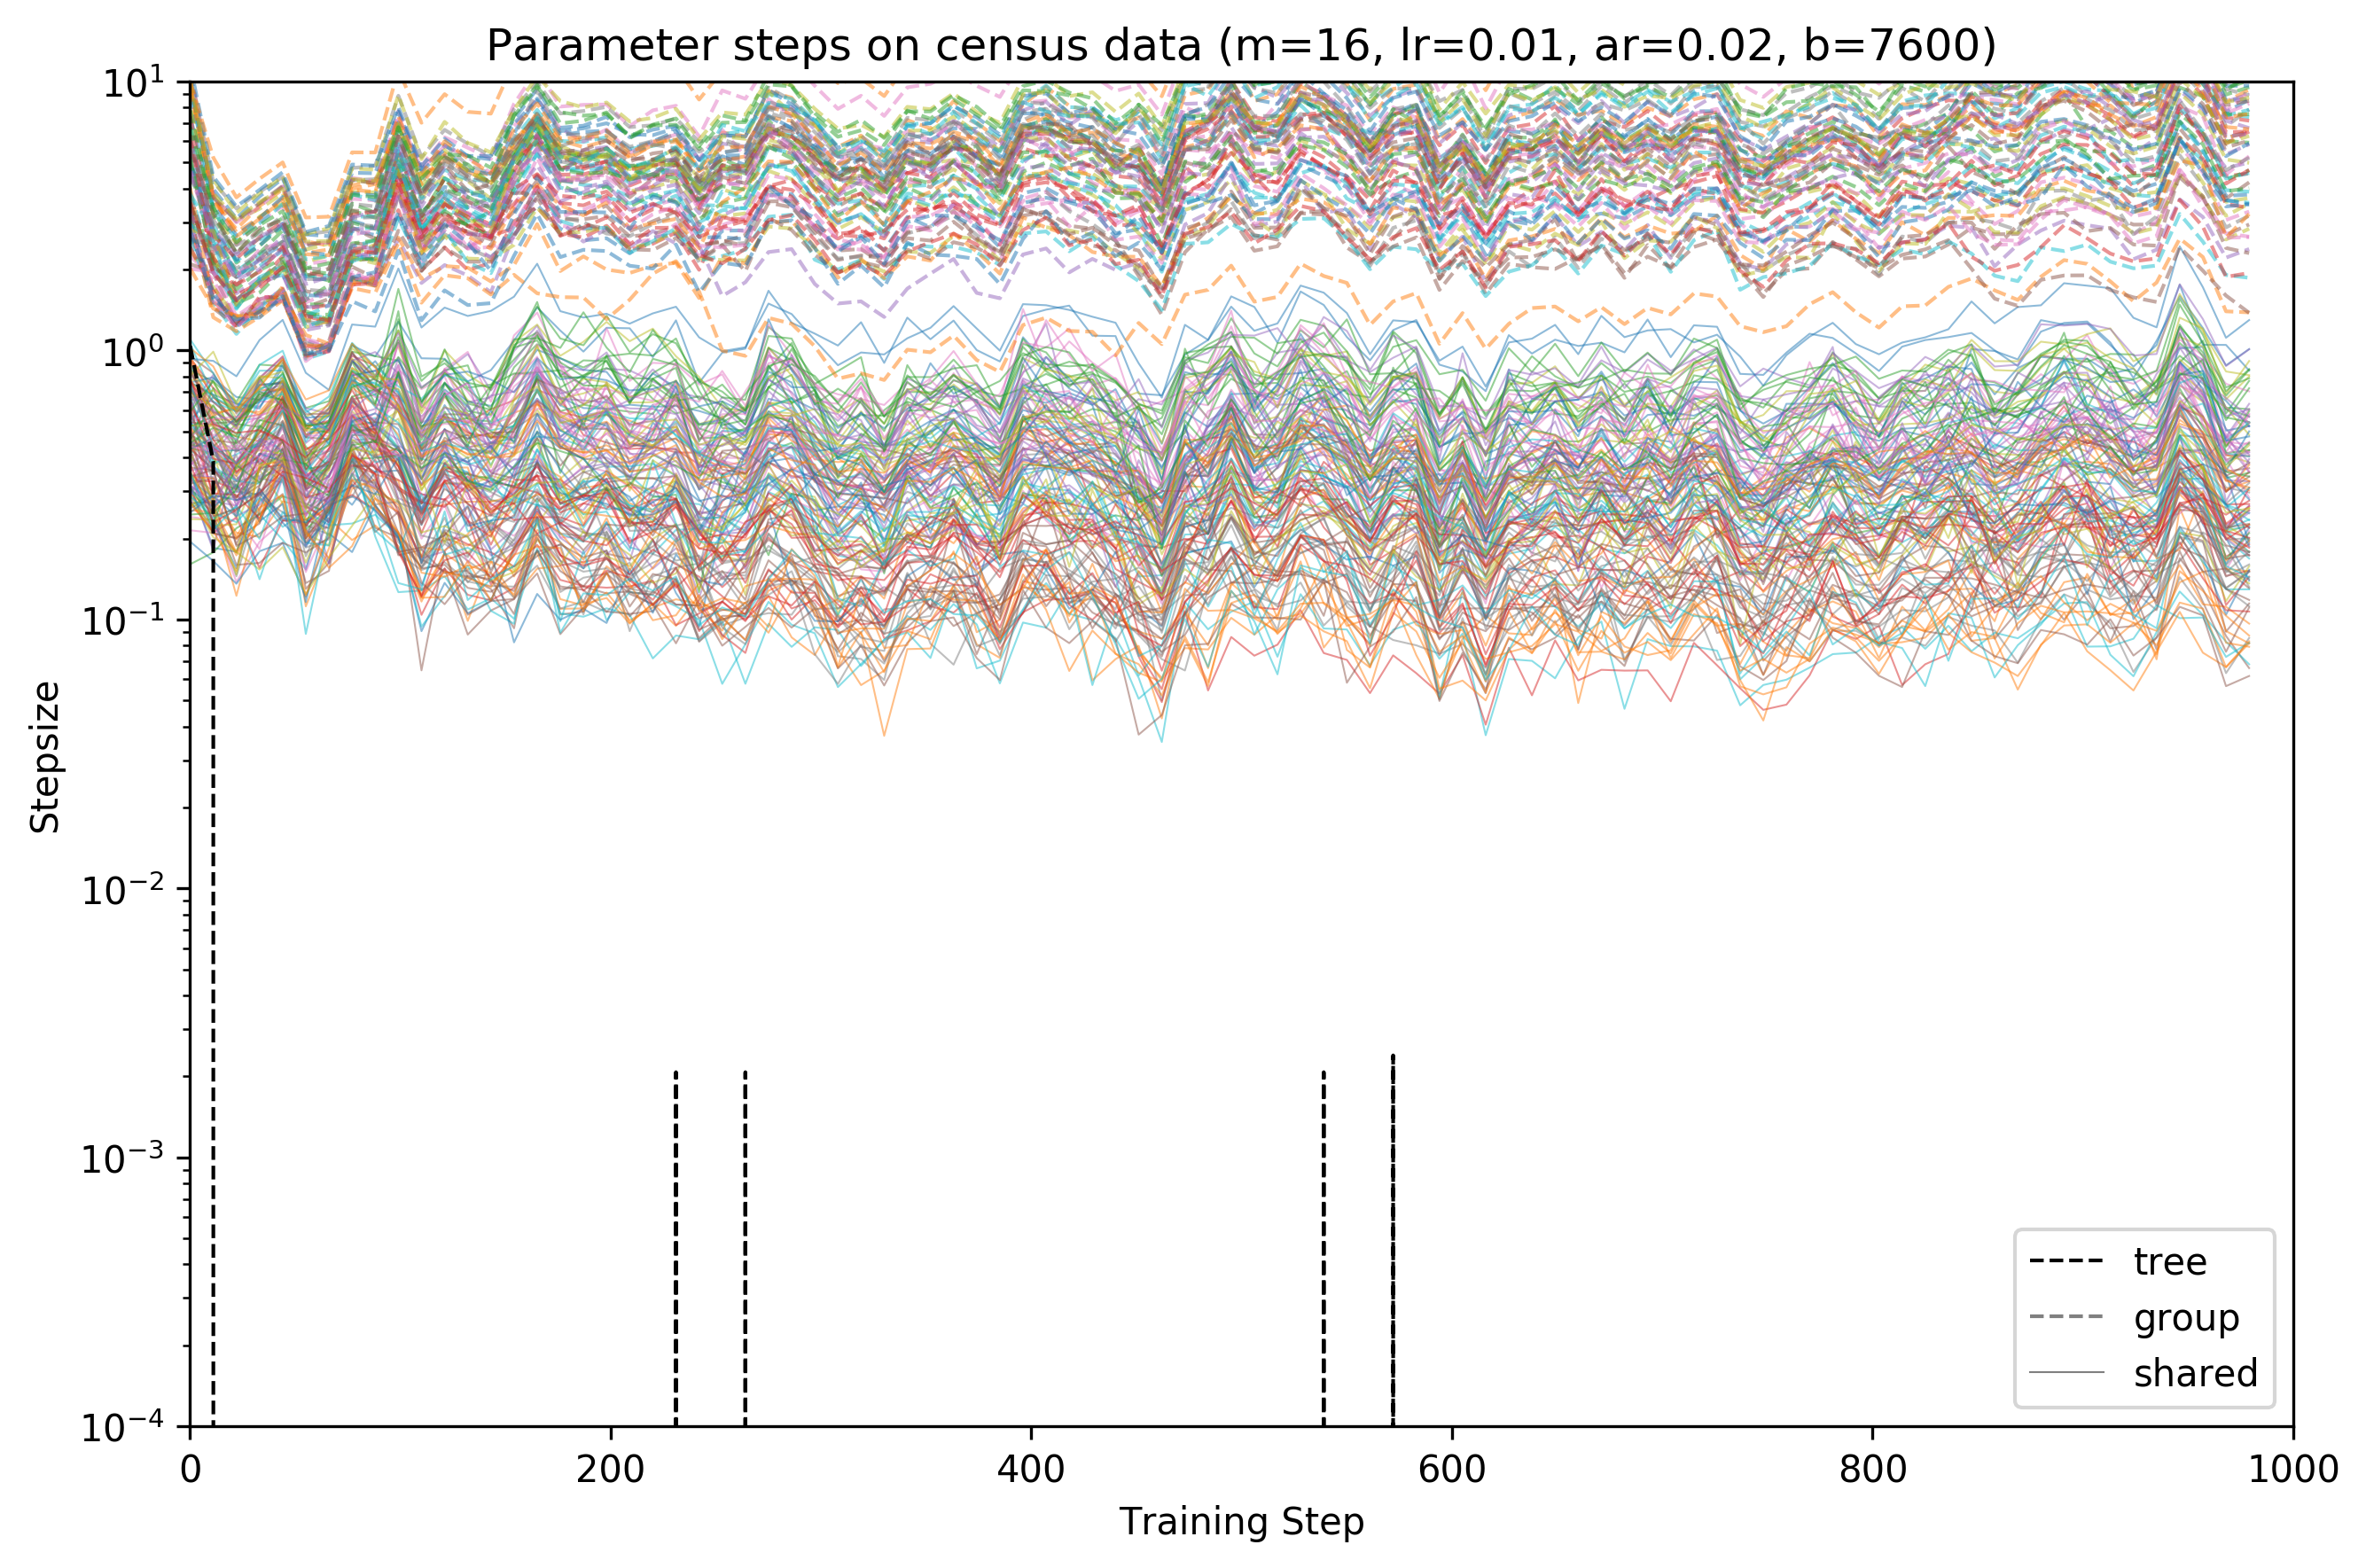

In [13]:
factor = (1 + len(stepsizes) // 100)
pyplot.figure(figsize=(9, 6), dpi=300)
for key in stepsizes[-1]:
    series = downsample([s.get(key, 0) for s in stepsizes], factor)
    X = range(0, len(series) * factor, factor)
    if key == 'tree':
        pyplot.plot(X, series, 'k--', label="tree", lw=1)
    else:
        if "_shared_" in key:
            style = dict(lw=0.5)
        else:
            style = dict(lw=1.0, linestyle='--')
        pyplot.plot(X, series, alpha=0.5, **style)
pyplot.plot([], color='gray', lw=1.0, linestyle='--', label='group')
pyplot.plot([], color='gray', lw=0.5, label='shared')
pyplot.ylabel('Stepsize')
pyplot.xlabel('Training Step')
pyplot.xlim(0, len(meta["losses"]))
pyplot.ylim(1e-4, 1e1)
pyplot.yscale('log')
pyplot.title('Parameter steps on {} data (m={}, lr={}, ar={}, b={})'.format(
             args.dataset, args.capacity, args.learning_rate,
             args.annealing_rate, args.batch_size))
pyplot.legend(loc='best')
pyplot.tight_layout()

In [14]:
from IPython.display import HTML
tree = print_tree(model.edges, [f.name for f in model.features])
HTML('<pre><p style="font-size: 10pt; line-height: 11pt;">{}</p></pre>'.format(tree))

## Comparison

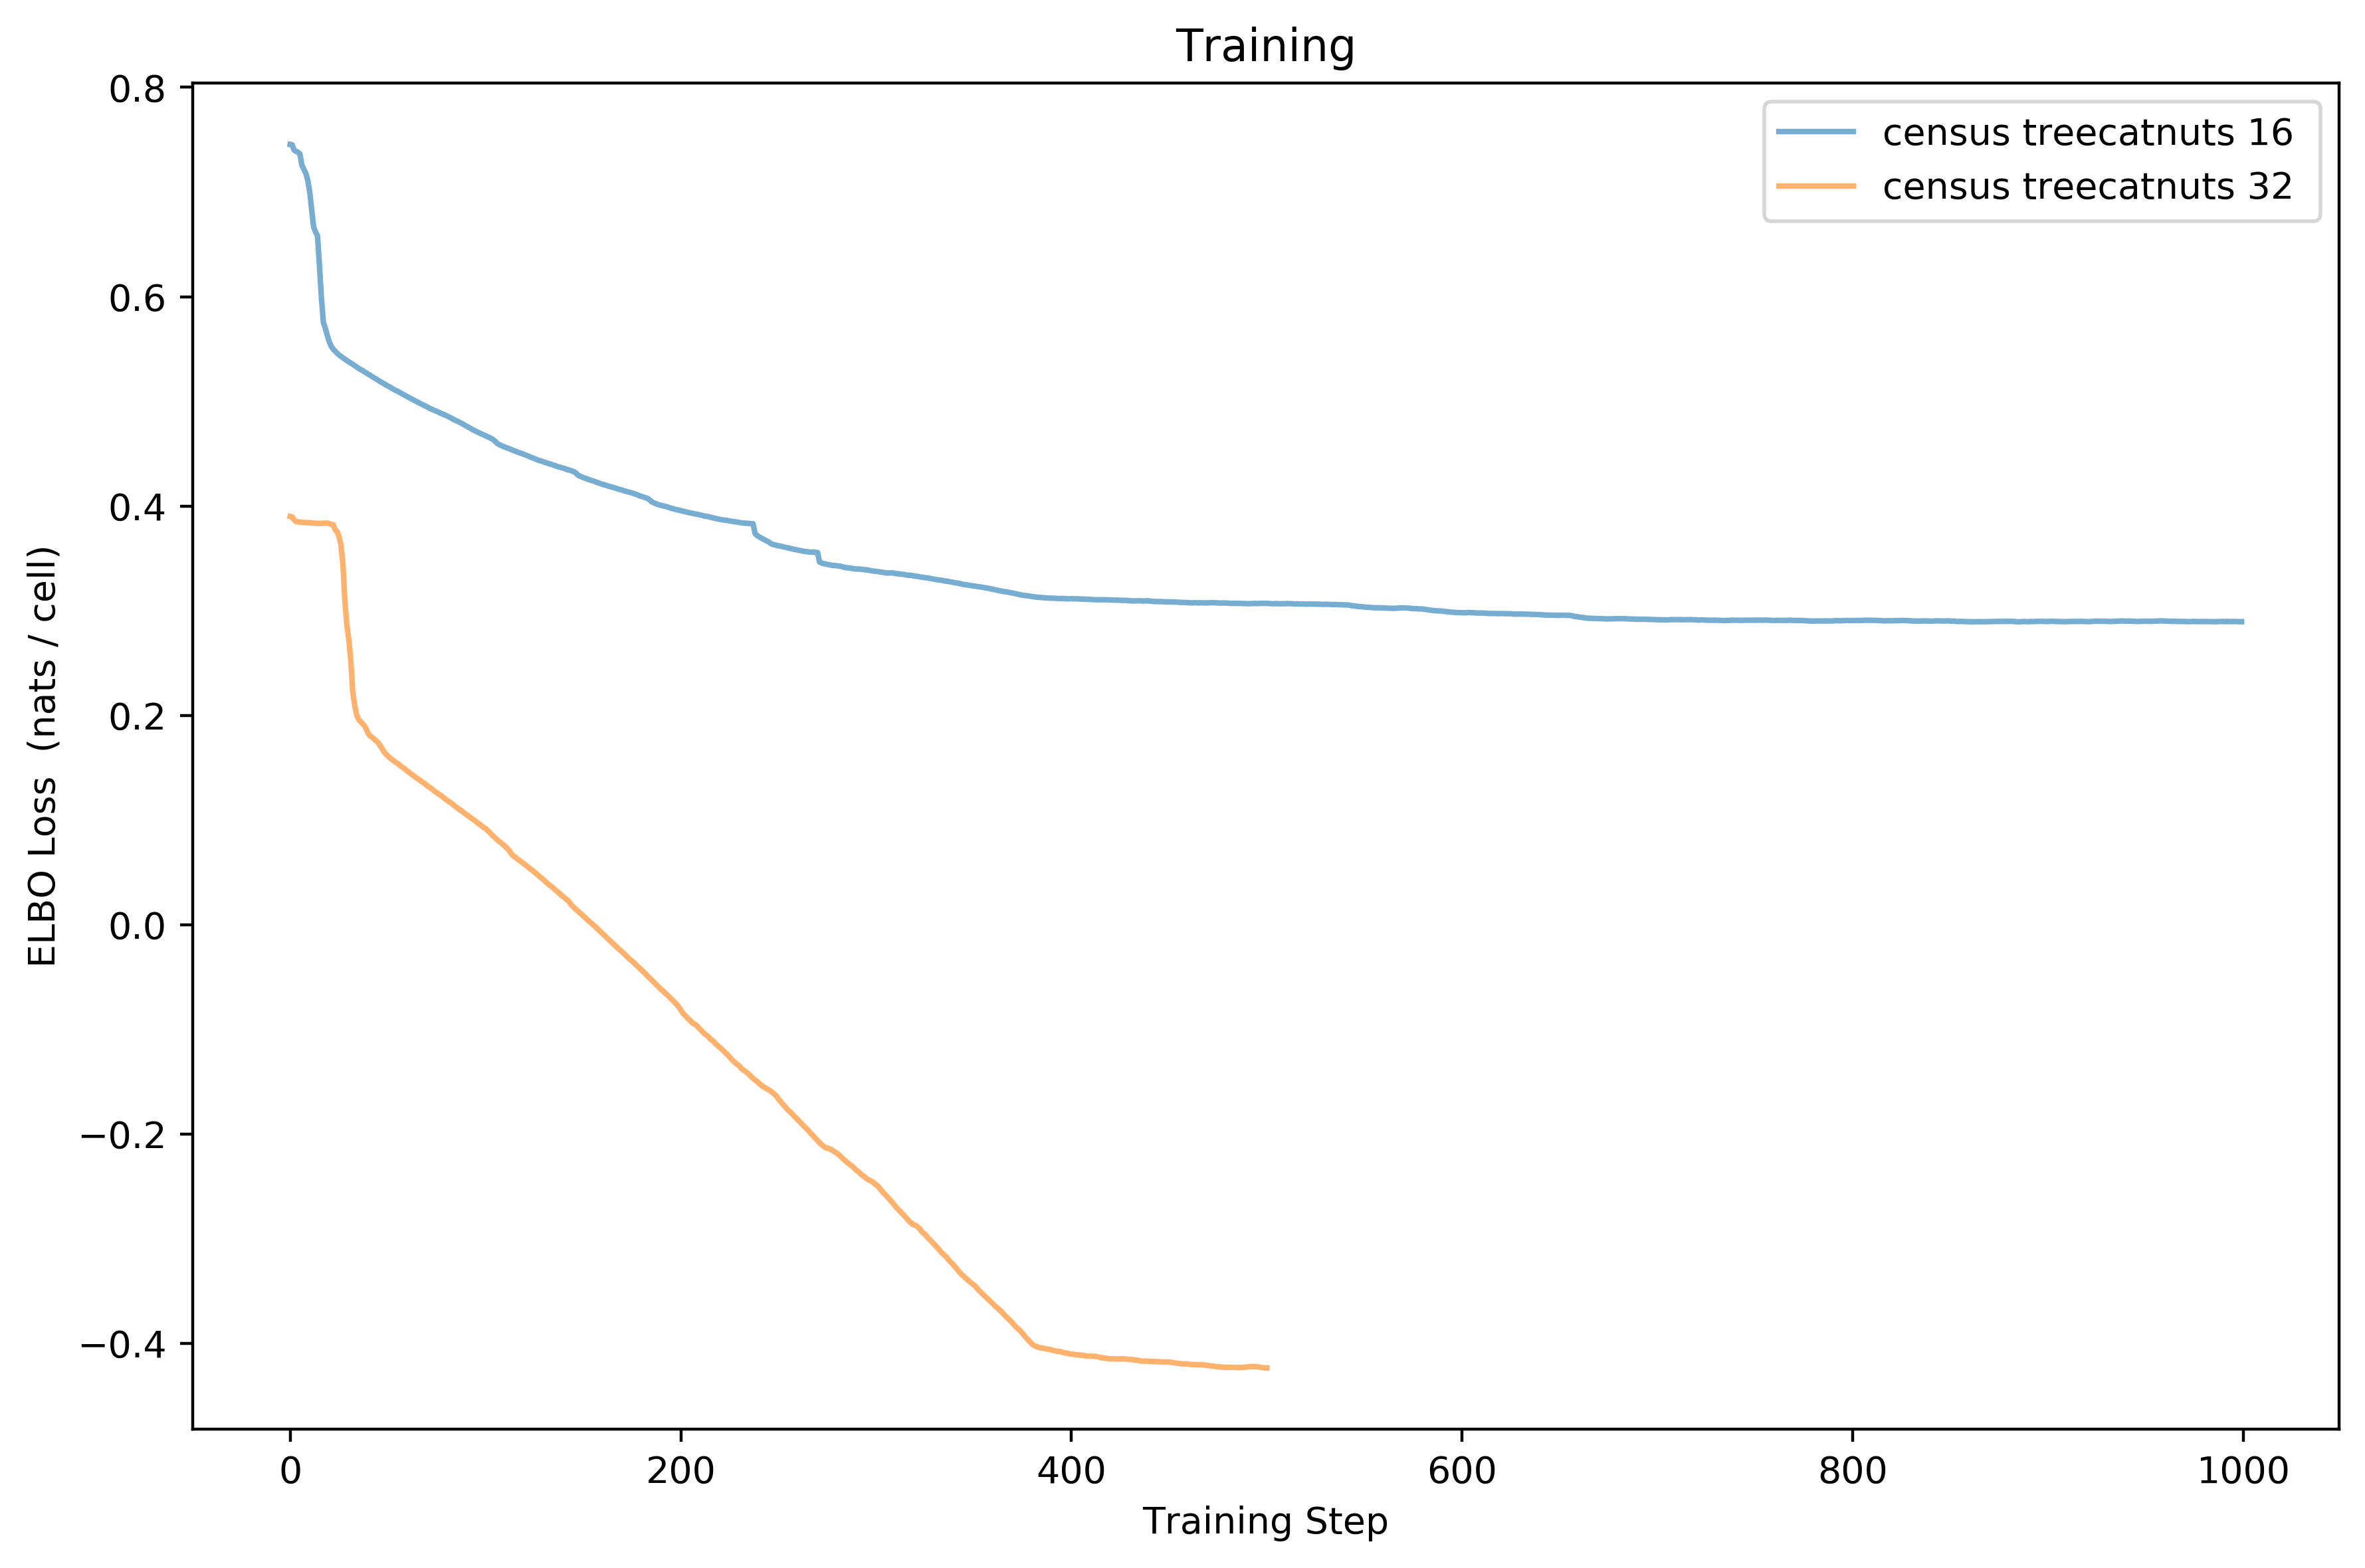

In [16]:
PATTERN = 'census.treecatnuts.*'
paths = glob.glob('results/train/{}.meta.pkl'.format(PATTERN))
datasets = [(path[:-len('meta.pkl')].replace('.', ' '), load_object(path))
            for path in paths]
datasets.sort(key=lambda path_meta: path_meta[1]["losses"][-1], reverse=True)
assert datasets

pyplot.figure(figsize=(9, 6), dpi=400)
for name, meta in datasets:
    args = meta['args']
    pyplot.plot(meta['losses'], label=os.path.basename(name), alpha=0.6)
    pyplot.ylabel('ELBO Loss  (nats / cell)')
    pyplot.xlabel('Training Step')
# pyplot.yscale('log')
pyplot.title('Training')
pyplot.legend(loc='best')
pyplot.tight_layout()